In [1]:
import networkx as nx
import os
import numpy as np
import pandas as pd
from func_modules import ControllerGraph
from tabulate import tabulate
import matplotlib.pyplot as plt

# Homework 5 from Group 18

Authors:

- Simone Di Gregorio / Matricola: 2042237
- Mattia Manna / Matricola: 1886817
- Paolo Leoni / Matricola: 1894985
- Francesco Obiso / Matricola: 1908398

## Data pre-processing and graphs setup

### Clean the dataframes

We read the datasets from the `csv` files, then we clean them according to the required steps in the `readme` file describing the homework:
- Space at the end and slash at the end are removed in the names from `hero_network`.
- Rows inducing loops are removed.
- Solve the Spider-Man problem.

In [2]:
# Read the dataframes
edges = pd.read_csv(os.path.join('data', 'edges.csv'))
hero_network = pd.read_csv(os.path.join('data', 'hero-network.csv'))
nodes = pd.read_csv(os.path.join('data', 'nodes.csv'))

In [3]:
# This simple Regex substitution solves slash and space problem in hero network
hero_network['hero1'] = hero_network.hero1.str.replace(r'/$|\s$', '', regex=True)
hero_network['hero2'] = hero_network.hero2.str.replace(r'/$|\s$', '', regex=True)

# Remove rows inducing loops in the graph
hero_network = hero_network[~(hero_network.hero1 == hero_network.hero2)].copy()

In [4]:
# Fix Peter Parker name
hero_network.loc[hero_network.hero1 == 'SPIDER-MAN/PETER PAR', 'hero1'] = 'SPIDER-MAN/PETER PARKER'
hero_network.loc[hero_network.hero2 == 'SPIDER-MAN/PETER PAR', 'hero2'] = 'SPIDER-MAN/PETER PARKER'

### Build the graphs

Let's build the first graph, the one from `hero_network`, undirected and weighted, with weights decreasing as the number of common appearances in comics increases. The approach chosen is similar to an idf measure, with the weight being given by $\frac{1}{\log(x)+1}$.

In [5]:
# Count appearances of hero 1 and hero 2 (ordered)
hero_counts = hero_network.value_counts()
# Group with frozenset, this way we get count of appearances without taking into consideration the order
hero_counts = hero_counts.groupby(lambda x: frozenset(x)).sum()
# Move frozenset from index to column
hero_counts = hero_counts.reset_index(name = 'count')

# List constructor onto frozenset (because pd.Series requires order) and then pd.Series to split the lists and get two different series
# (resulting in a DataFrame). Then concatenate count Series with these other two we have obtained. This is close to the final dataset we need.
hero_counts = pd.concat([hero_counts['index'].apply(list).apply(pd.Series), hero_counts['count']], axis = 1)

hero_counts['weight'] = 1/(1+np.log(hero_counts['count'])) # Compute weights with something quite similar to idf weights
hero_counts.drop('count', axis = 1, inplace = True) # Drop count column, we don't need that anymore
hero_counts.rename({0: 'hero1', 1:'hero2'}, axis = 1, inplace = True) # Rename for tidiness

# Build the undirected graph from edgelist + weight attribute
hero_graph = nx.from_pandas_edgelist(hero_counts, source='hero1', target='hero2', edge_attr='weight')

Now we build the second graph, the one from edges and considering the node type. For this we need to use `nodes` and `edges`.

In [6]:
hero_comics_graph = nx.from_pandas_edgelist(edges, source='hero', target='comic')
nodes_attr_dict = nodes.set_index('node').to_dict(orient='index')
nx.set_node_attributes(hero_comics_graph, nodes_attr_dict)

We instantiate the controller object which is needed to call the functionalities. It is simply a class instantiated with the `edges` dataset in order to get the top hero nodes and provided with the `functionality` method calling the single functionalities internally, each with its specific arguments.

In [7]:
controller = ControllerGraph(edges) # Edges is passed for the top N heroes list

## Functionality 1: Explaining and Visualizing
### Heroes graph

In order to visualize some features of the network we will  use a function  created  in the backend implementation.
This function called ```func1``` take several arguments in input as:
- The graph
- The type of the graph:
    -  1 if the graph is relative to only the couples of heroes.
    -  2 if the graph is relative to heroes and comics.


As output we will have :

- The number of nodes of the graph.
- The network's density.
- The network's degree distribution.
- The average degree of the network.
- The network's Hubs (hubs are nodes having degrees more extensive than the 95th percentile of the degree distribution).
- Whether the Network is sparse or dense.

Also the function is builded to give different output according to the type of graph, for instance:
- The number of collaborations of each superhero with the others, only if type graph is 1.
- The number of heroes that have appeared in each comic, only if type graph is 2.

**Note**: A none value will be returned for number of collaborations when the type graph is equal to 1, the same will
be for the number of heroes when the type graph is equal to 2.


All this output are obtained using the built-in method from **networkx** combined with standard Python syntax.
In order to distinguish different cases, like type graph equal to one or two, we have used if statement.

In [8]:
number_of_nodes,number_of_collaborations,\
    heroes_in_comic,density,networks_degree_distribution,\
    average_degree,network_hubs,network = controller.functionality(1, hero_graph, graph_type= 1)

#### Table containing the following general information about the graph:

In [9]:
table = [['Number of nodes in the network', number_of_nodes], ['Density of the network', density],['Average degree of the network',average_degree],["The network is", network]]
print(tabulate(table, tablefmt='grid',numalign="right"))

+--------------------------------+----------------------+
| Number of nodes in the network | 6421                 |
+--------------------------------+----------------------+
| Density of the network         | 0.008107160063285336 |
+--------------------------------+----------------------+
| Average degree of the network  | 52.047967606291856   |
+--------------------------------+----------------------+
| The network is                 | Sparse               |
+--------------------------------+----------------------+


#### Table that lists the network's hubs

In [10]:
table=list(network_hubs)
tab=[[i,table[i]] for i in range(len(table))][:51]
print(tabulate(tab,tablefmt='github',headers=["ID","Network's hubs"]))

|   ID | Network's hubs       |
|------|----------------------|
|    0 | SUB-MARINER/NAMOR MA |
|    1 | THING/BENJAMIN J. GR |
|    2 | CLOAK/TYRONE JOHNSON |
|    3 | FURY, COL. NICHOLAS  |
|    4 | BANNER, BETTY ROSS T |
|    5 | HULK/DR. ROBERT BRUC |
|    6 | BANSHEE/SEAN CASSIDY |
|    7 | BLACK KNIGHT V/DANE  |
|    8 | BLACK PANTHER/T'CHAL |
|    9 | MR. FANTASTIC/REED R |
|   10 | DR. DOOM/VICTOR VON  |
|   11 | ENCHANTRESS/AMORA/HE |
|   12 | FIRESTAR/ANGELICA JO |
|   13 | SILVER SURFER/NORRIN |
|   14 | BLACK KING/SEBASTIAN |
|   15 | SPIDER-WOMAN II/JULI |
|   16 | USAGENT/CAPTAIN JOHN |
|   17 | MAGMA/AMARA AQUILLA  |
|   18 | HUMAN TORCH ANDROID  |
|   19 | KARMA/XI'AN COY MANH |
|   20 | KARNAK [INHUMAN]     |
|   21 | RICHARDS, FRANKLIN B |
|   22 | RED SKULL/JOHANN SCH |
|   23 | QUICKSILVER/PIETRO M |
|   24 | BOOMER/TABITHA SMITH |
|   25 | CAGE, LUKE/CARL LUCA |
|   26 | CAPTAIN MARVEL II/MO |
|   27 | WASP/JANET VAN DYNE  |
|   28 | MEDUSA/MEDUSALITH AM |
|   29 |

#### Plot depicting the number of collaborations of each hero in descending order
In order to have a better visualization for the chart we take the first 50 heroes in descending order.
This selection was only done for the visualization, and this is why the functionality was not called directly considering the top 50 heroes.

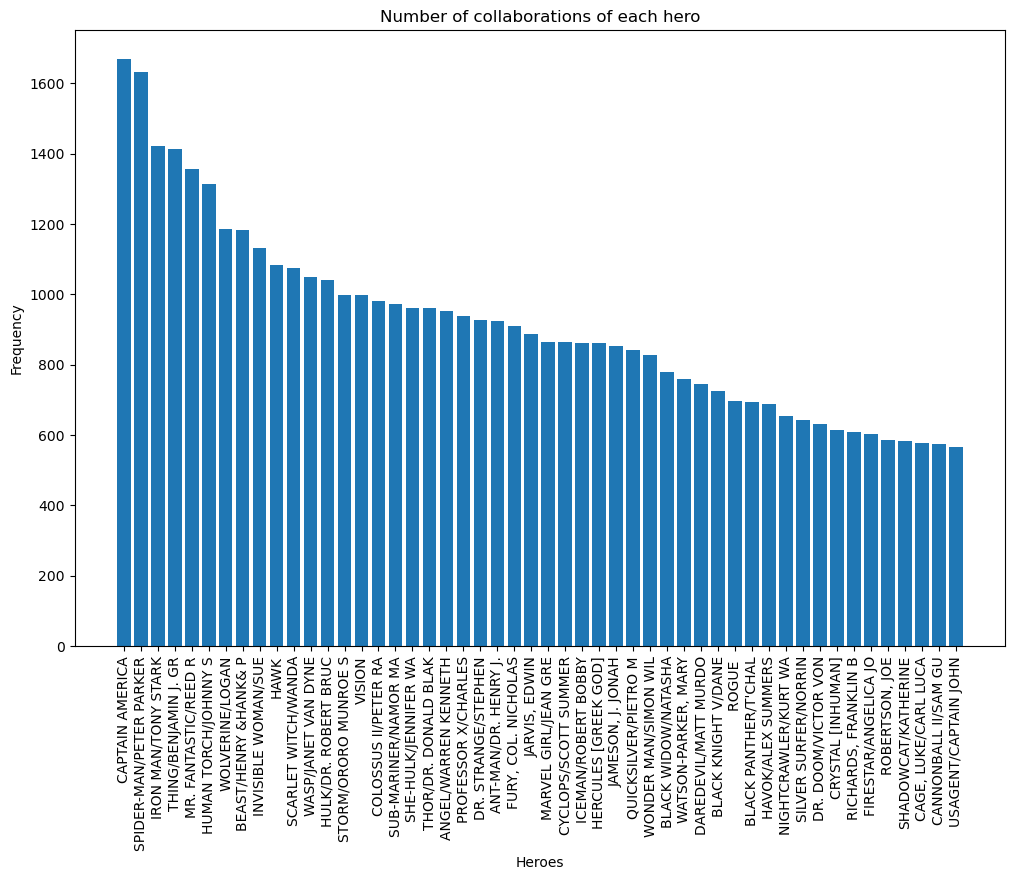

In [11]:
top_50=dict(number_of_collaborations.most_common(50))
plt.gcf().set_size_inches((12, 8))
plt.tick_params(axis='x', labelrotation=90)
plt.title("Number of collaborations of each hero")
plt.xlabel("Heroes")
plt.ylabel("Frequency")
plt.bar(top_50.keys(),top_50.values())
plt.show()

#### Plot depicting the degree distribution of the network

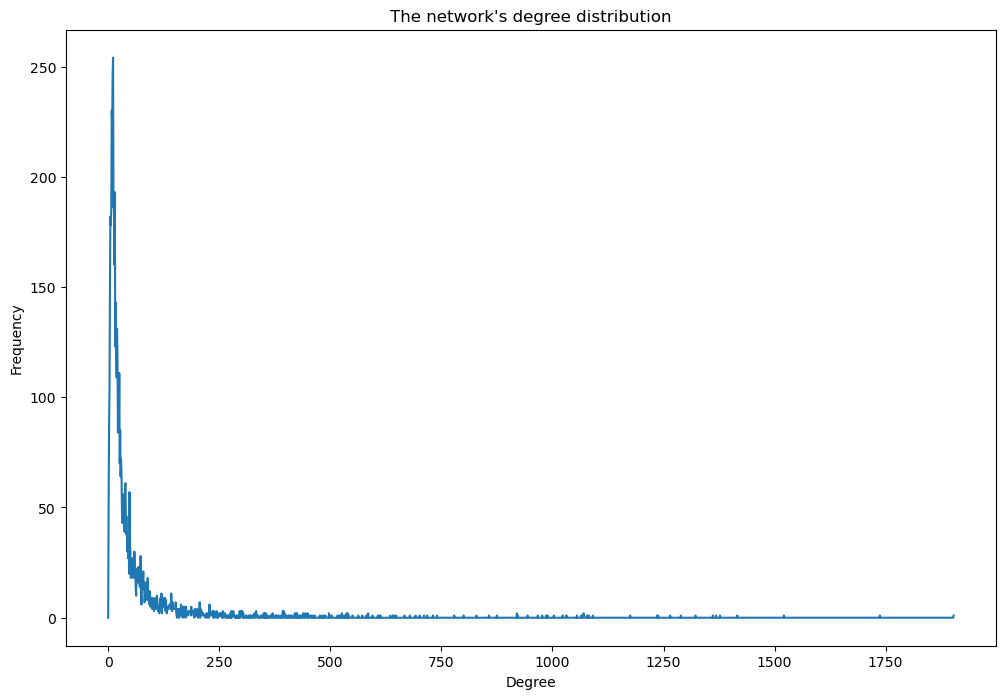

In [12]:
plt.gcf().set_size_inches((12, 8))
plt.title("The network's degree distribution")
plt.plot(networks_degree_distribution)
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.show()

### Heroes and comics

In [13]:
number_of_nodes,number_of_collaborations,\
    heroes_in_comic,density,networks_degree_distribution,\
    average_degree,network_hubs,average_clustering = controller.functionality(1, hero_comics_graph, graph_type= 2)

#### Table containing the following general information about the graph:

In [14]:
table = [['Number of nodes in the network', number_of_nodes], ['Density of the network', density],['Average degree of the network',average_degree],["Average clustering coefficient",average_clustering]]
print(tabulate(table, tablefmt='grid',numalign="right"))

+--------------------------------+-----------------------+
| Number of nodes in the network | 19090                 |
+--------------------------------+-----------------------+
| Density of the network         | 0.0005274512833807265 |
+--------------------------------+-----------------------+
| Average degree of the network  | 10.068517548454688    |
+--------------------------------+-----------------------+
| Average clustering coefficient | Sparse                |
+--------------------------------+-----------------------+


#### Table that lists the network's hubs

In [15]:
table=list(network_hubs)
tab=[[i,table[i]] for i in range(len(table))][:51]
print(tabulate(tab,tablefmt='github',headers=["ID","Network's hubs"]))

|   ID | Network's hubs   |
|------|------------------|
|    0 | COC 1            |
|    1 | Q 14             |
|    2 | T 440            |
|    3 | ASM 23           |
|    4 | H2 278           |
|    5 | SWII 7           |
|    6 | MX '01           |
|    7 | XFOR 10          |
|    8 | A 273            |
|    9 | A 274            |
|   10 | A 275            |
|   11 | AUP 4            |
|   12 | M/SHSW 1         |
|   13 | M/SHSW 10        |
|   14 | M/SHSW 11        |
|   15 | M/SHSW 12        |
|   16 | M/SHSW 2         |
|   17 | M/SHSW 3         |
|   18 | M/SHSW 4         |
|   19 | M/SHSW 5         |
|   20 | M/SHSW 6         |
|   21 | M/SHSW 7         |
|   22 | M/SHSW 8         |
|   23 | M/SHSW 9         |
|   24 | T2 14            |
|   25 | W2 164           |
|   26 | Q 25             |
|   27 | H2 397           |
|   28 | ROM 65           |
|   29 | ROM 66           |
|   30 | BP3 16           |
|   31 | BP3 27           |
|   32 | NW 55            |
|   33 | NW 56      

#### Plot depicting the number of heroes who appeared in each comic, sorted in descending order
In order to have a better visualization for the chart we take the first 50 comics in descending order.
This selection was only done for the visualization, and this is why the functionality was not called directly considering the top 50 heroes.

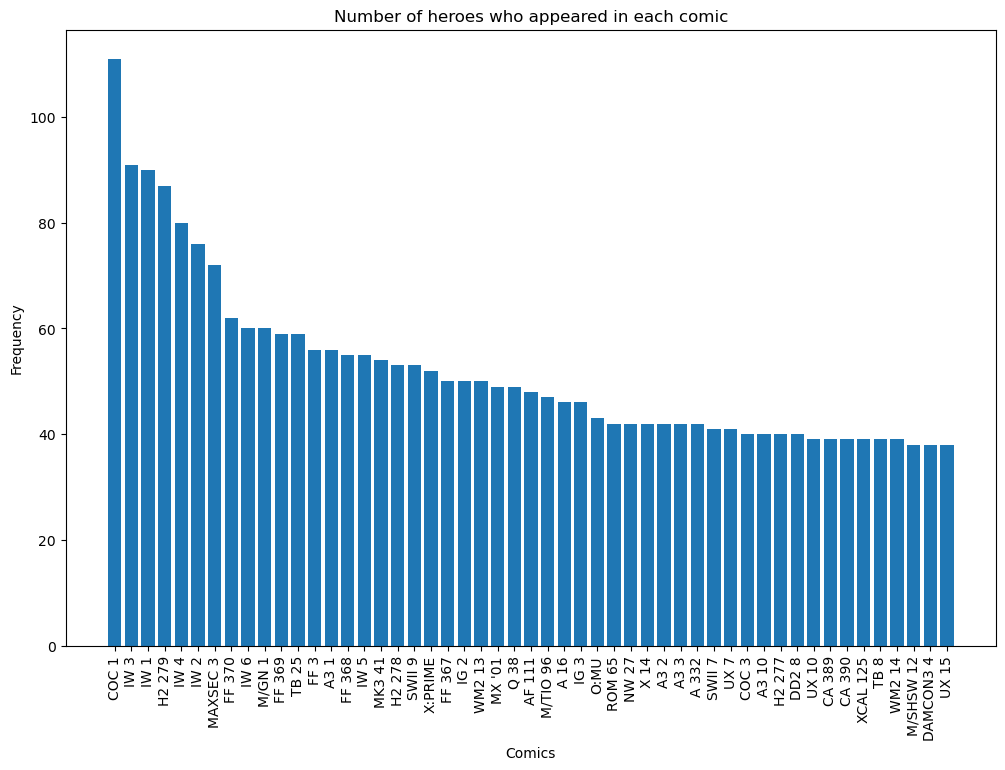

In [16]:
top_50 = dict(sorted(heroes_in_comic.items(), key = lambda x: x[1], reverse = True)[:51])
plt.gcf().set_size_inches((12, 8))
plt.tick_params(axis='x', labelrotation=90)
plt.title("Number of heroes who appeared in each comic")
plt.xlabel("Comics")
plt.ylabel("Frequency")
plt.bar(top_50.keys(),top_50.values())
plt.show()

#### Plot depicting the degree distribution of the network

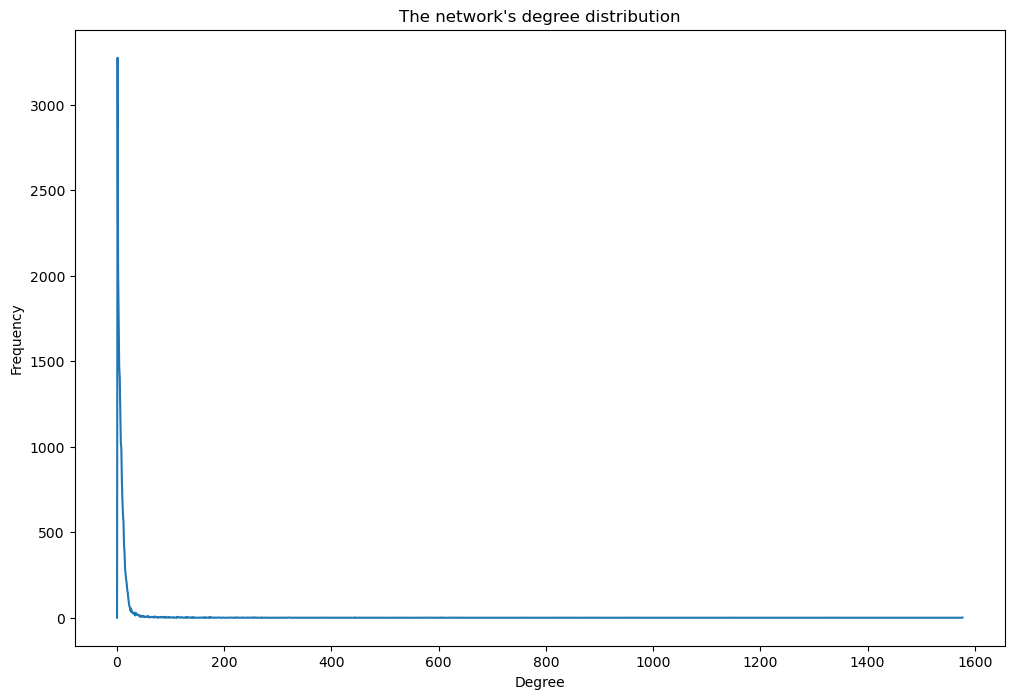

In [17]:
plt.gcf().set_size_inches((12, 8))
plt.title("The network's degree distribution")
plt.plot(networks_degree_distribution)
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.show()

## Functionality 2: explaining and visualizing

We call `func2`, which you can inspect in the `functionality_2.py` module in the `func_modules` package, to take the values of the matric chosen by the user on the entire graph (or subgraph if the user chooses the number N of `top_heroes`) and on the hero selected. To take this values we use some functions imported by `networkx` like `nx.betweenness_centrality()`,  `nx.pagerank_numpy()`, `nx.closeness_centrality()` and `nx.degree_centrality()`.
Then we calculate the average of the requested centrality measure for all of the network's nodes.

In [18]:
#The metric values calculated on the graph and on the selected hero
metric_values, hero_metric_value = controller.functionality(2,hero_graph, hero = 'CAPTAIN AMERICA', metric = 'betweenness_centrality')

In [19]:
mean_centrality = np.array(list(metric_values.values())).mean() #The average of the requested centrality measure for all of the network's nodes

In [20]:
table = [['Avarage of the centrality measure', mean_centrality], ['Centrality measure for the given hero', hero_metric_value]]
print(tabulate(table, tablefmt='grid'))

+---------------------------------------+-------------+
| Avarage of the centrality measure     | 0.000308364 |
+---------------------------------------+-------------+
| Centrality measure for the given hero | 0.159808    |
+---------------------------------------+-------------+


- The ***betweenness centrality*** of a node measures the extent to which the node lies on the shortest paths between other nodes. A high betweenness centrality value means that the node is located on many shortest paths and, therefore, has a *central position* within the graph. On the other hand, a low betweenness centrality value indicates that the node is not on many shortest paths and, therefore, has a *less central position* within the graph.

- The ***PageRank*** of a node measures the importance of the node within the graph, with higher values indicating more important nodes. A high PageRank value means that the node is more likely to be visited by a random walker and, therefore, has a *more central position* within the graph. On the other hand, a low PageRank value indicates that the node is less likely to be visited and, therefore, has a *less central position* within the graph.

- The ***closeness centrality*** of a node measures the average distance from the node to all other nodes in the graph. A high closeness centrality value means that the node is close to many other nodes and, therefore, has a *central position* within the graph. On the other hand, a low closeness centrality value indicates that the node is far from many other nodes and, therefore, has a *less central position* within the graph.

- The ***degree centrality*** of a node measures the number of edges incident to the node. A high degree centrality value means that the node has many connections to other nodes and, therefore, has a *central position* within the graph. On the other hand, a low degree centrality value indicates that the node has few connections to other nodes and, therefore, has a *less central position* within the graph.

If a user has a high *betweenness centrality* value, this means that they are located on many shortest paths within the graph and are therefore considered to be a key connector. If the user has a low *betweenness centrality* value but a high *PageRank* value, this may mean that they are not on many shortest paths but are still considered to be an important node within the graph due to the high number of visits they receive. Similarly, if the user has a high *closeness centrality* value, this means that they are close to many other nodes in the graph and are therefore considered to be a central node. If the user has a high *degree centrality* value, this means that they have many connections to other nodes and are therefore considered to be a central node within the graph.

## Functionality 3: explaining and visualizing

For the third functionality we are asked to build a function which, given the bipartite graph with heroes and comics, returns the shortest walk passing through a given set of heroes in order (the order of first visit is what matters), with the endpoints of the walk also given.

The straightforward implementation we can think of here is simply repeatedly using Breadth-First Search to get from one node to the next one in the sequence, exploiting the fact that we [know that](http://aris.me/contents/teaching/data-mining-ds-2019/resources/CLRS-graphs,bfs,dfs.pdf) exploring with BFS we get the shortest path. The ordered sequence of shortest paths is bound to be the shortest walk.

Therefore, `func_3`, which you can inspect in the `functionalities_34.py` module in the `func_modules` package, is simply a manual implementation of Breadth-First Search with a few tweaks. More specifically:

- As we have already said, BFS is the core of the functionality, but not the functionality as a whole. BFS is repeated, with the current target then becoming the source of the following iteration. The iteration starts with the first endpoint as the first source node and ends with the second endpoint as the last target node.
- Of course, we don't just need to explore the nodes reachable from a source, but we also need to store the path from the source to the visited node, each time. This is actually quite simple to do, and it can be done by simply storing in the BFS queue not only the identifier of the visited node, but also the path with which we can reach it from the source. This allows to have some _persistent memory_ in the process as more levels are explored. When the current target is reached, the `walk` list is extended with the shortest path found in the current iteration with BFS.
- We need to take into consideration the order of first visit. This simply amounts to hardcode the fact that the BFS should not visit nodes which follow the target one (for the current iteration) in the sequence.
- If at any iteration of our _repeated BFS_ the current target node cannot be reached with BFS, then the whole execution has to halt, print a proper warning message and return an empty list (the empty walk). This can be done by adding a boolean flag which is set to True only when the current target node is found at the current iteration.

Now we call the functionality through the `functionality` method of the controller, considering the whole graph. `seq` is the sequence of heroes we have to pass through, `endpoints` is the tuple giving the starting and terminal endpoints.

In [21]:
shortest_walk = controller.functionality(3, hero_comics_graph,
                         seq = ['ABOMINATION/EMIL BLO', 'ANCIENT ONE', 'IRON MAN/TONY STARK', 'SPIDER-MAN/PETER PARKER'],
                         endpoints=('CAPTAIN AMERICA', 'CAPTAIN MARVEL/CAPTA'))

Now we visualize the result in a proper way. We make different calls to the NetworkX plotting functions (which use the matplotlib engine and are thus compatible with the usual framework) in order to build a complex visualization. For the plot we consider only the nodes and the edges in the walk, with the edges between them not present in the walk which are anyway drawn, but with a very low value of the `alpha` channel and with limited width.

As required, labels are added to the edges in order to highlight the ordering, which is anyway clear even without those. Since the graph is at this point planar, we can have a relatively clear visualization with the `planar_layout` function for the dictionary of positions. The hero nodes are blue and the comic nodes are red, and this difference in color highlights the fact that the graph is bipartite (a red always follows a blue, and vice-versa). It was also requested to print the comic nodes in the shortest walk: those are printed in the upper left corner of the plot.

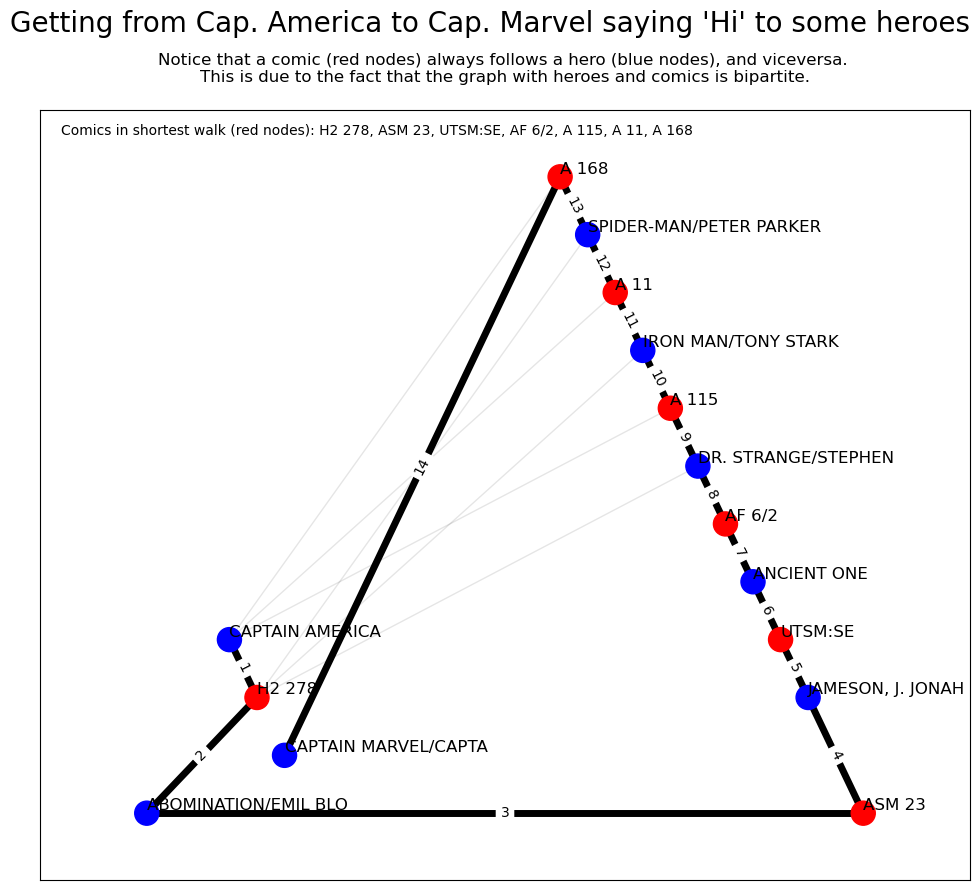

In [22]:
tuples_walk = list()
dict_labels_edge = dict()
for idx in range(len(shortest_walk)-1):  # Build list of edges in the walk and build dictionary of order indexes for edges
    tuples_walk.append((shortest_walk[idx], shortest_walk[idx+1]))
    dict_labels_edge[(shortest_walk[idx], shortest_walk[idx+1])] = idx+1

# Get subgraph to plot
plot_graph = nx.subgraph_view(hero_comics_graph, filter_node=lambda x: x in shortest_walk,
                              filter_edge = lambda x, y: (x, y) in tuples_walk or (y, x) in tuples_walk)
plt.gcf().set_size_inches((12, 10)) # Change size of the plot

dict_pos = nx.planar_layout(plot_graph) # Dictionary of positions
nx.draw_networkx_edges(plot_graph, pos = dict_pos, width=5)  # Draw edges in the walk

# Draw nodes with specific color, with labels (the names)
nx.draw_networkx_nodes(plot_graph, pos = dict_pos,
                       node_color = ['blue' if plot_graph.nodes[x]['type'] == 'hero' else 'red' for x in plot_graph.nodes])
nx.draw_networkx_labels(plot_graph, pos = dict_pos, horizontalalignment='left', verticalalignment='bottom')

# Draw edges with specific labels (the index highlighting the ordering)
nx.draw_networkx_edges(nx.subgraph_view(hero_comics_graph, filter_node=lambda x: x in shortest_walk),
                       pos = dict_pos, alpha = 0.1)
nx.draw_networkx_edge_labels(plot_graph, pos = dict_pos, edge_labels=dict_labels_edge, font_size=10)

plt.margins(x = 0.09)  # Add some margin in order not to cut labels
plt.text(-1.2, 0.45, s = 'Comics in shortest walk (red nodes): '+
                         ', '.join([x for x in shortest_walk if hero_comics_graph.nodes[x]['type'] == 'comic']))
plt.suptitle('Getting from Cap. America to Cap. Marvel saying \'Hi\' to some heroes', size = 20)
plt.title('Notice that a comic (red nodes) always follows a hero (blue nodes), and viceversa. \n'
          'This is due to the fact that the graph with heroes and comics is bipartite.', pad = 20)

plt.show()

## Functionality 4: Explaining and Visualizing

The main idea here is exploiting the [max-flow min-cut theorem](https://en.wikipedia.org/wiki/Max-flow_min-cut_theorem) which allow us to link max-flow problems to min-cut problems. In other words we have to disconnect the source from the sink inducing a cut/a partition, and we need to do that with the minimum cost/cumulative weight possible, thus finding the s-t cut with the minimum capacity over the set of all the possible ones.

Doing that is not trivial and requires some relatively advanced tools. First of all we need to build the residual graph, i.e. the graph representing the flow in the maximized scenario. In the original graph, the weight of an edge is its capacity, i.e. the maximum amount of flow it can carry. With the residual graph, we have a **directed** graph, since the flow has a direction: the residual capacity of each edge is given by $r_{i,j} = c_{i,j}-f_{i,j}$, with $c_{i,j}$ as the original capacity/the weight of the undirected edge between $i$ and $j$ and $f_{i,j}$ being the **directed** flow passing through the edge in the specific direction, which is negative if the flow goes backwards. It is trivial to notice, but I will stress it: $r_{i, j} \neq r_{j,i}$. To give an example, $r_{i, j} = 0 \rightarrow r_{j,i} \geq c_{j,i} = c_{i, j}$

For each original undirected edge we thus have two directed edges. Now, suppose that we can reach a node from the source only using edges with non-null residual capacity: we will not be able to reach the sink (otherwise we would have an augmenting path) and the nodes we reach are the ones which represent one of the two subsets induced by the minimum s-t cut, i.e. the one with minimum cost/capacity disconnecting source and sink. The edges we need to get a cut-set are the ones connecting these reachable nodes to the non-reachable ones.

This is exactly what we are doing in our implementation:
- We use [Edmonds-Karp](https://en.wikipedia.org/wiki/Edmonds–Karp_algorithm) (the [Ford-Fulkerson algorithm](https://en.wikipedia.org/wiki/Ford–Fulkerson_algorithm)) from NetworkX set of algorithms. This allows us to have the residual graph returned.
- Once we have that, we perform Breadth-First Search from the source using only the edges with non-null residual capacity. The nodes we reach are the ones in the first subset induced by the minimum s-t cut.
- Once we have the labels/the name of the nodes of the first subset, we simply cut each connection in the original graph with the others in the second. For that, we can use the `edge_boundary` function from NetworkX.

In [23]:
num_edges_lost, edges_lost, cut_graph = controller.functionality(4, hero_graph, 35,
                                                                 hero_2='SPIDER-MAN/PETER PARKER', hero_1='IRON MAN/TONY STARK')

Now we visualize the output of the functionality: notice that we are considering only the top 35 heroes since otherwise it would be impossible to see anything clearly. The problem is that by taking the top 35 heroes the resulting graph of heroes (we are choosing that one since it is weighted) is complete: this means that in general the cut-set will always contain only edges adjacent to the source or the sink. It is just simple logic, jumping to a neighbour of source or sink for the cut produces a combinatorial explosion: instead of removing one edge in order to induce the cut from source to sink, we now have to remove $N-2$, with $N$ as the number of nodes. Apart from very strange distributions of the weights, this kind of situation induces s-t cut where the cut-set is adjacent to source or sink. The result is a cut $C(S, T)$ where $S = \{s\}$ or with $T = \{t\}$, with $s$ being the source and $t$ being the sink.

Notice that we would have an identical situation also increasing the number of nodes (increasing the top heroes number). Considering the graph without filtering for top heroes allows for the smaller cut to have more than one vertex, but the idea remains the same.

In order to visualize the min-cut s-t for the 35 heroes we chose not to plot two graphs - with and without the edges in the cut-set-, but only one highlighting the edges in the cut-set, which combines the two perspectives. The edges in the cut-set are shown in red, which is also the colour of source and sink. The rest of the edges are anyway shown, but with a lower alpha channel, which is anyway higher - relatively speaking - as the weight increases.

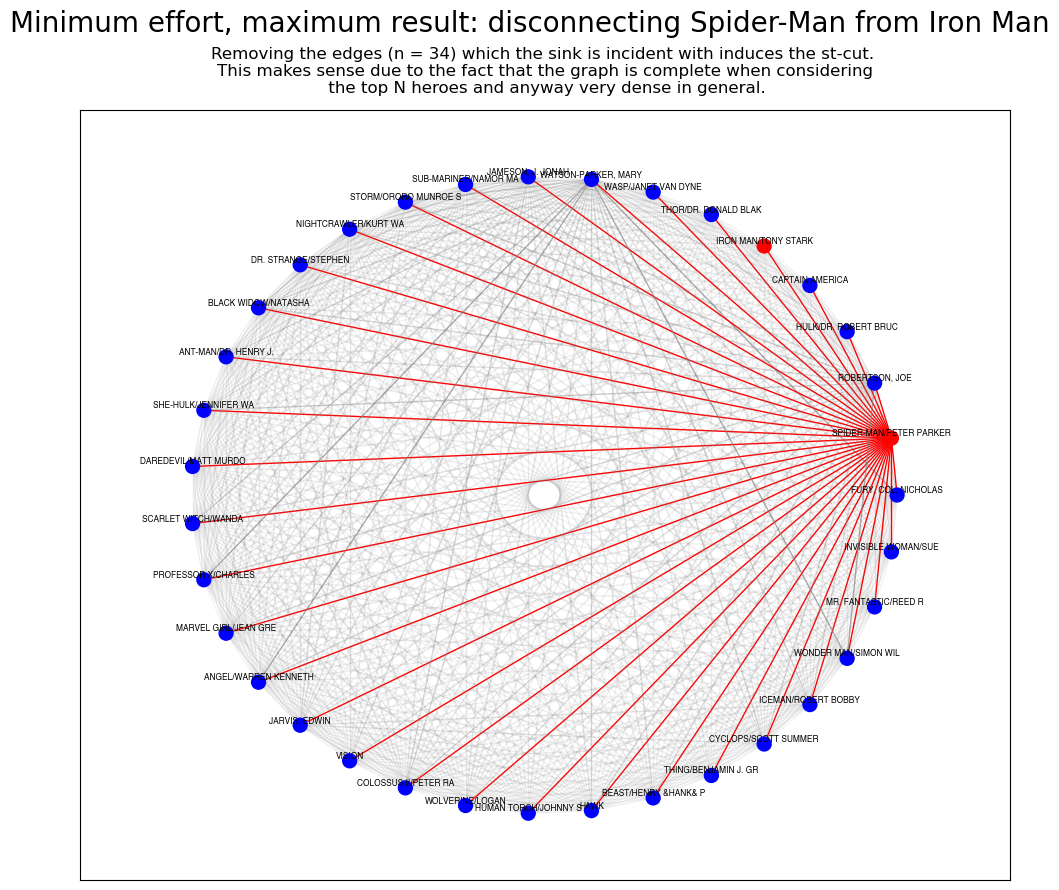

In [24]:
plt.gcf().set_size_inches((12, 10)) # Increase size of plot
plot_graph = cut_graph.copy() # Copy graph (without the edges in the cut-set) to avoid modifying in place
plot_graph.add_edges_from(edges_lost) # Add edges which were lost (the one in the cut-set)

dict_pos = nx.circular_layout(plot_graph) # Circular layout because it is more clear
# Color source and sink
color_node = ['red' if node == 'SPIDER-MAN/PETER PARKER' or node == 'IRON MAN/TONY STARK' else 'blue' for node in plot_graph.nodes]
nx.draw_networkx_nodes(plot_graph, pos = dict_pos, node_size = 100, node_color=color_node) # Draw nodes
# Draw labels
nx.draw_networkx_labels(plot_graph, pos = dict_pos, font_size=6, font_family='helvetica', verticalalignment='bottom', font_weight='heavy')

# Set color list, red for edges in cut-set, gray otherwise
color_edges = ['red' if (edge in edges_lost or tuple(reversed(edge)) in edges_lost) else 'gray' for edge in plot_graph.edges]
# Set alpha channel, a function of the weight, 1 for edges in the cut-set (which do not have weight attribute)
alpha_edges = [x[2]/1.5 if x[2] else 1 for x in plot_graph.edges(data='weight')]
# Draw the edges with the alpha and color info we have built
nx.draw_networkx_edges(plot_graph, pos = dict_pos, alpha = alpha_edges, edge_color = color_edges)

# Add some margins
plt.margins(x=0.10)
plt.suptitle('Minimum effort, maximum result: disconnecting Spider-Man from Iron Man', size = 20)
plt.title(f'Removing the edges (n = {num_edges_lost}) which the sink is incident with induces the st-cut. \n'
          'This makes sense due to the fact that the graph is complete when considering\n'
          ' the top N heroes and anyway very dense in general.', pad = 12)
plt.show()

# Functionality 5: explaining and visualizing

For this functionality is required to find the communities that are in the first graph, `hero_graph`.
In a network we can find nodes that can be easily grouped into (potentially overlapping) sets, such that each set of nodes is densely connected internally: this type of group is called **community**. There are several algorithms used to find network communities, we'll use the [Girvan-Newman](https://en.wikipedia.org/wiki/Girvan–Newman_algorithm) algorithm: this algorithm detects communities by progressively removing from the network edges with the higher edge betweenness centrality, i.e. the ones contained in more shortest paths.

In [25]:
from func_modules.functionalities_5 import faitabella, colorgraph, identifygroup

numedges, graph1, checkhero, graph= controller.functionality(5,
        hero_graph, num_heroes = 50, hero_1 = 'CAPTAIN AMERICA', hero_2 = 'IRON MAN/TONY STARK')

comps = list(nx.connected_components(graph1)) # lists of different connected component

In [26]:
print('This is the number of removed edges: ', numedges)

This is the number of removed edges:  1015


As we can see in the table the second community is composed only by one node: it's due to the extremely high density of the graph when considering the top 50 heroes. Please notice that this algorithm requires computing betweeness centrality, which is an extremely expensive metric. Therefore, we are very constrained in the amount of nodes we can have in the graph if we want to limit the execution time to something bearable.

In [27]:
faitabella(graph1,comps)       # communities' table 

Group 0                  Group 1
-----------------------  --------------------
FURY, COL. NICHOLAS      HUMAN TORCH/JOHNNY S
SILVER SURFER/NORRIN
SPIDER-MAN/PETER PARKER
ROBERTSON, JOE
HULK/DR. ROBERT BRUC
CAPTAIN AMERICA
THOR/DR. DONALD BLAK
IRON MAN/TONY STARK
WASP/JANET VAN DYNE
CAPTAIN BRITAIN/BRIA
NELSON, FRANKLIN FOG
WATSON-PARKER, MARY
BLACK PANTHER/T'CHAL
CANNONBALL II/SAM GU
JAMESON, J. JONAH
SUB-MARINER/NAMOR MA
STORM/ORORO MUNROE S
NIGHTCRAWLER/KURT WA
DR. STRANGE/STEPHEN
HERCULES [GREEK GOD]
BLACK WIDOW/NATASHA
ANT-MAN/DR. HENRY J.
SHE-HULK/JENNIFER WA
DAREDEVIL/MATT MURDO
SCARLET WITCH/WANDA
PROFESSOR X/CHARLES
QUICKSILVER/PIETRO M
ODIN [ASGARDIAN]
MARVEL GIRL/JEAN GRE
DR. DOOM/VICTOR VON
ANGEL/WARREN KENNETH
RICHARDS, FRANKLIN B
JARVIS, EDWIN
VISION
SHADOWCAT/KATHERINE
COLOSSUS II/PETER RA
PUNISHER II/FRANK CA
WOLVERINE/LOGAN
PARKER, MAY
HAWK
BEAST/HENRY &HANK& P
THING/BENJAMIN J. GR
CYCLOPS/SCOTT SUMMER
ICEMAN/ROBERT BOBBY
WONDER MAN/SIMON WIL
JONES, RICHARD MILHO
MR. FA

The nodes are very connected and the graph density is very high (again, also due to the fact that we are considering the top 50 heroes).

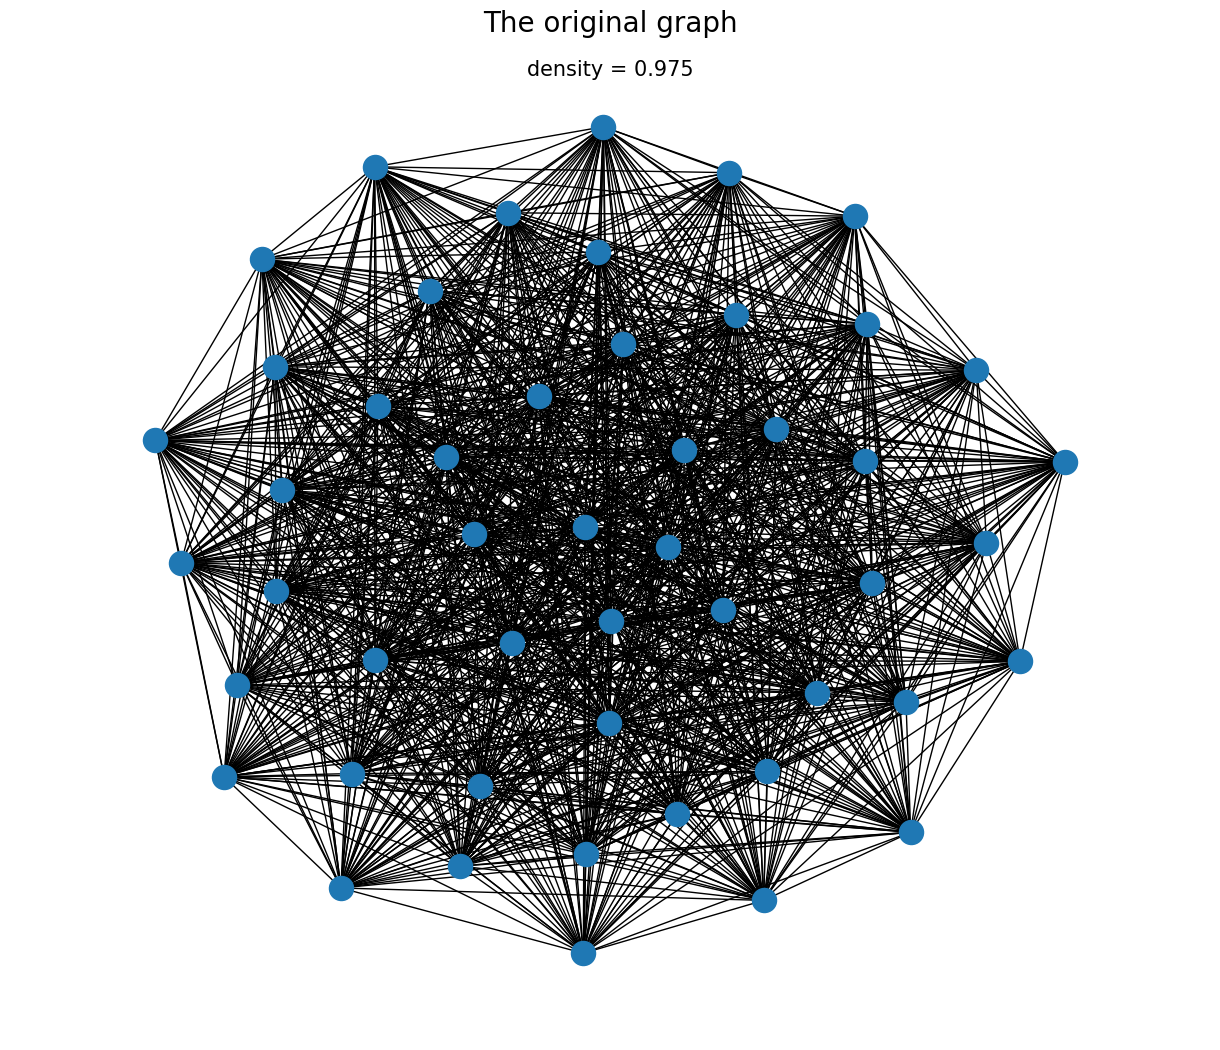

In [28]:
plt.gcf().set_size_inches((12, 10))
nx.draw(graph, with_labels=False)          # plot original graph
plt.margins(x=0.10)
plt.suptitle(f'density = {round(nx.density(graph), 3)}', size = 15)
plt.title('The original graph', size = 20)
plt.show()

As per the output of our functionality, we have two communities: one extremely dense and the other with only one node

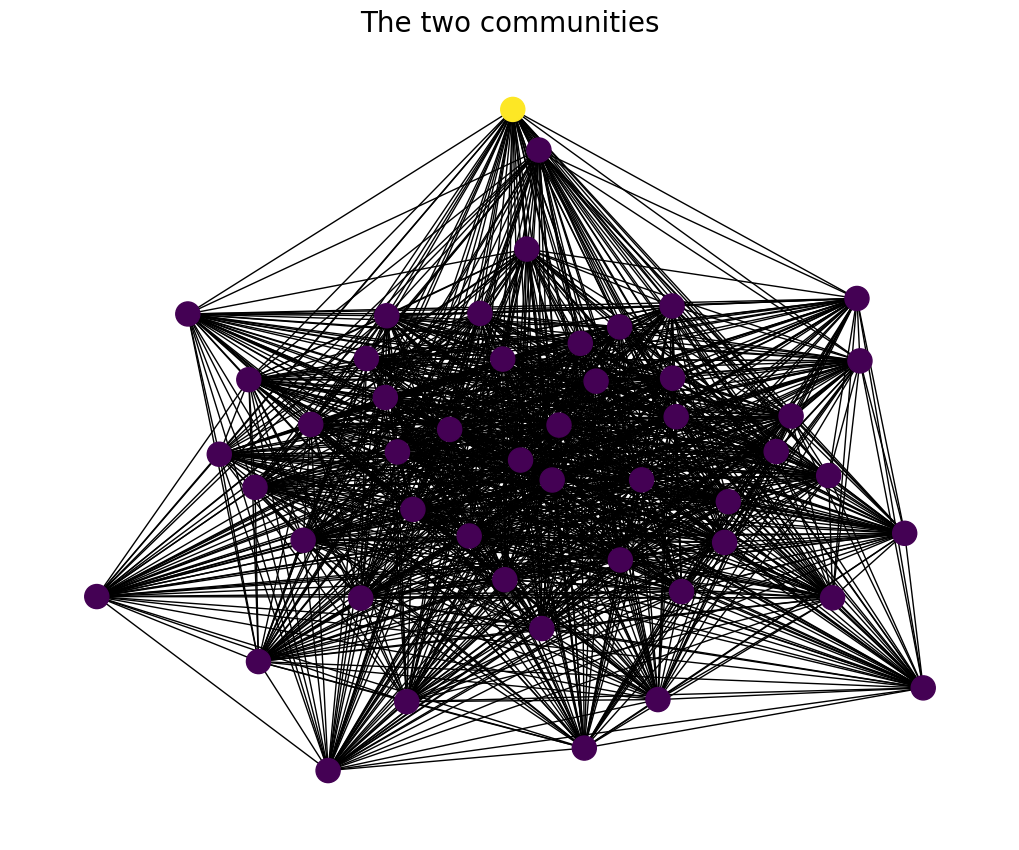

In [29]:
plt.gcf().set_size_inches((10, 8))
color_map, pos = colorgraph(graph1, comps)  # function which defines nodes' color and position by belonging community
nx.draw(graph, pos, node_color = list(color_map.values()), with_labels = False)
plt.title('The two communities', size = 20)
plt.show()

As we can see _CAPTAIN AMERICA_ and _IRON MAN/TONY STARK_ are in the same community.

Plot the final graph and identify the community/communities of 'CAPTAIN AMERICA' and 'IRON MAN/TONY STARK'


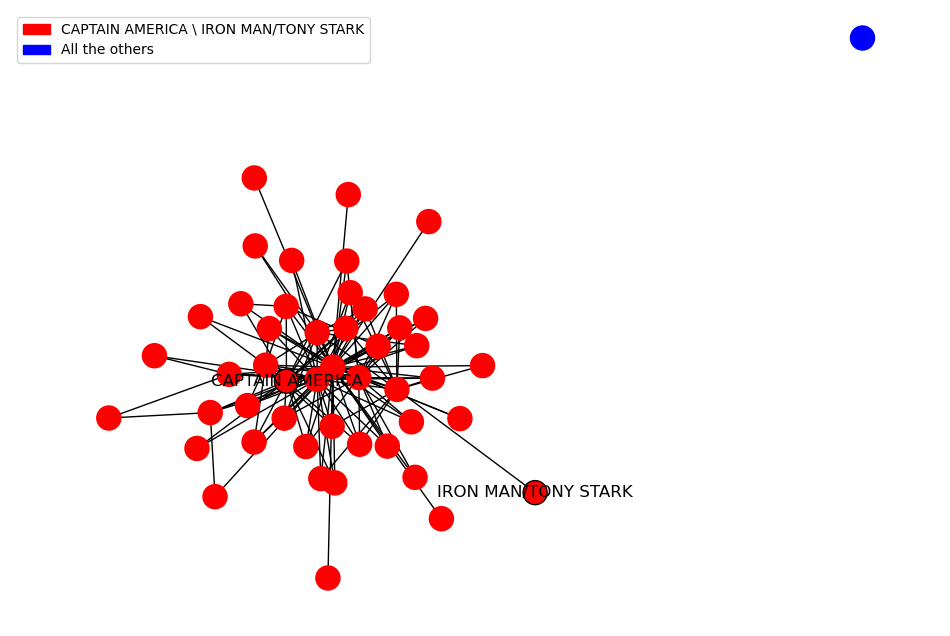

In [36]:
plt.gcf().set_size_inches((12, 8))
plt.margins(x=0.10)
print("Plot the final graph and identify the community/communities of 'CAPTAIN AMERICA' and 'IRON MAN/TONY STARK'")
idhero = identifygroup(graph1,'CAPTAIN AMERICA','IRON MAN/TONY STARK', color_map)  # given heroes' communities

## Algorithmic question

In this algorithmic question we have to unlock a smartphone; in particular, we are given a 3x3 grid and the direction of each line segment and we have to find how many possible patterns we need to try out to unlock it. Things simplify a lot since the pattern cannot intersect with itself.

The first point is to check whether Alex has glimpsed the directions well.

In [37]:
def con_ord(stringa: str) -> int:
    """
    Function which check if 'stringa' has the structure we want.
    :param stringa: The directions.
    :return: An integer whose value checks whether the input directions have the structure we want.
        If it is greater than 0 it is ok, if it is negative, it is not.
    """
    
    o = ['R','L']  # horizontal letter
    v = ['U','D']  # vertical letter
    
    i = 0
    while i < len(stringa)-1 and i != -1:  # check if the two type of letters take turns
        if (stringa[i] in o and stringa[i+1] in v) or (stringa[i] in v and stringa[i+1] in o):
            i += 1
        else: 
            i = -1
            
    return i

Now given a point in the 3x3 grid we find how many patterns there are, indicating with $[0,0],[0,1],[0,2],[1,0],[1,1],[1,2],[2,0],[2,1],[2,2]$ the different points, in which $[0,0]$ is the point lower left (w.r.t. grid), with the first item representing the horizontal side and the second item the vertical one.

In [38]:
def find_one(stringa:str, ora:[int, int], passati: list[list[int, int], ...]) -> int:
    """
    Function which finds how many patterns from 'ora' and given 'passati', the
    points the pattern already went through:
    
    :param stringa: The directions.
    :param ora: Starting point.
    :param passati: Points already passed by the pattern.
    :return: The number of possible patterns starting from 'ora'.
    """
    s = 0
    
    if min(ora)<0 or max(ora)>2 or (ora in passati): # if the pattern goes out from the grid => stop
        pass
    
    else:
        passati.append(ora)     # append the starting point in passati
        if stringa == '':       # if stringa == '', we have found a pattern
            s += 1
        else:
            pas1 = passati.copy()   # copy twice 'passati'
            pas2 = passati.copy()
            ora1 = ora.copy()       # copy starting point
            
            if stringa[0] == 'R':      # if the first letter in 'stringa' is 'R', go right
                ora1[0] = ora1[0] + 1  # only one step
                s += find_one(stringa[1:], ora1, pas1) # find the patterns after this step
                ora1[0] = ora1[0] + 1  # two steps
                s += find_one(stringa[1:], ora1, pas2) # find the patterns after this step
                
            elif stringa[0] == 'L':
                ora1[0] = ora1[0] - 1
                s += find_one(stringa[1:], ora1, pas1)
                ora1[0] = ora1[0] - 1
                s += find_one(stringa[1:], ora1, pas2)
            
            elif stringa[0] == 'U':
                ora1[1] = ora1[1] + 1
                s += find_one(stringa[1:], ora1, pas1)
                ora1[1] = ora1[1] + 1
                s += find_one(stringa[1:], ora1, pas2)
            
            else:
                ora1[1] = ora1[1] - 1
                s += find_one(stringa[1:], ora1, pas1)
                ora1[1] = ora1[1] - 1
                s += find_one(stringa[1:], ora1, pas2)
    
    return s    # return the number of patterns 

Finally put the two previous functions together: check whether the directions seen by Alex indicate a possible pattern, and find the number of patterns from each grid point.

In [39]:
def find_all(stringa) -> int:
    """
    Function which counts how many possible patterns there are which start from each grid point.
    :param stringa: The directions.
    :return: The number of possible patterns.
    """
    check = con_ord(stringa)   # is 'stringa' a good pattern?
    if check == -1:
        return print("Alex didn't glimps well...")
    else:
        punti = [[0,0],[0,1],[0,2],[1,0],[1,1],[1,2],[2,0],[2,1],[2,2]]
        totale = 0
        for i in punti:  # Sum the number of patterns found which start from each grid point
            totale += find_one(stringa, i, [])
    return totale

Let's see an example: Alex had seen Sarah move DOWN ('D'), RIGHT ('R') and UP ('U').
He has to try out 15 possible patterns.

In [40]:
find_all('DRU')

15